In [1]:
from IPython.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 16px; }</style>")) # Increase font size

# Larger figures

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import auc, roc_curve, f1_score, accuracy_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import cross_val_score

# Practice #1

Classification trees with Titanic data file

## Data Loading

Variable description:

- **survived:	Survival (target variable) - 0 = No, 1 = Yes**
- pclass:	Ticket class - 1 = 1st, 2 = 2nd, 3 = 3rd
- sex:	    Sex
- age:	    Age in years
- sibsp:	# of siblings / spouses aboard the Titanic
- parch:	# of parents / children aboard the Titanic
- ticket:	Ticket number
- fare:	    Passenger fare
- cabin:	Cabin number
- embarked:	Port of Embarkation - C = Cherbourg, Q = Queenstown, S = Southampton


Let's load the dataset and review null values

In [2]:
import openpyxl

# Red data
filename = 'titanic.xlsx'
df = pd.read_excel(filename, 1) #it has two sheets, we load the 2nd one
df.head()

,pclass,survived,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,1,1,29.0000,0,0,24160,211.3375,B5,2.0
1,1,1,0,0.9167,1,2,113781,151.5500,C22 C26,2.0
2,1,0,1,2.0000,1,2,113781,151.5500,C22 C26,2.0
3,1,0,0,30.0000,1,2,113781,151.5500,C22 C26,2.0
4,1,0,1,25.0000,1,2,113781,151.5500,C22 C26,2.0


In [3]:
print ("Records and variables: ", df.shape)
print ("Column names: ", df.columns.to_list())

Records and variables:  (1309, 10)
Column names:  ['pclass', 'survived', 'sex', 'age', 'sibsp', 'parch', 'ticket', 'fare', 'cabin', 'embarked']


In [4]:
df.isnull().sum() #null values

pclass         0
survived       0
sex            0
age          263
sibsp          0
parch          0
ticket         0
fare           1
cabin       1014
embarked       2
dtype: int64

4 variables with null values, mostly cabin and age. <BR>
We can discard cabin since it appears to be meaningless (and also ticket). <BR> 
We will need to delete records with missing values, otherwise the model will fail

In [5]:
df['cabin'].unique() 

array(['B5', 'C22 C26', 'E12', 'D7', 'A36', 'C101', nan, 'C62 C64', 'B35',
       'A23', 'B58 B60', 'D15', 'C6', 'D35', 'C148', 'C97', 'B49', 'C99',
       'C52', 'T', 'A31', 'C7', 'C103', 'D22', 'E33', 'A21', 'B10', 'B4',
       'E40', 'B38', 'E24', 'B51 B53 B55', 'B96 B98', 'C46', 'E31', 'E8',
       'B61', 'B77', 'A9', 'C89', 'A14', 'E58', 'E49', 'E52', 'E45',
       'B22', 'B26', 'C85', 'E17', 'B71', 'B20', 'A34', 'C86', 'A16',
       'A20', 'A18', 'C54', 'C45', 'D20', 'A29', 'C95', 'E25', 'C111',
       'C23 C25 C27', 'E36', 'D34', 'D40', 'B39', 'B41', 'B102', 'C123',
       'E63', 'C130', 'B86', 'C92', 'A5', 'C51', 'B42', 'C91', 'C125',
       'D10 D12', 'B82 B84', 'E50', 'D33', 'C83', 'B94', 'D49', 'D45',
       'B69', 'B11', 'E46', 'C39', 'B18', 'D11', 'C93', 'B28', 'C49',
       'B52 B54 B56', 'E60', 'C132', 'B37', 'D21', 'D19', 'C124', 'D17',
       'B101', 'D28', 'D6', 'D9', 'B80', 'C106', 'B79', 'C47', 'D30',
       'C90', 'E38', 'C78', 'C30', 'C118', 'D36', 'D48', 'D47', '

In [6]:
# droppping cabin and ticket
df.drop(labels=['cabin', 'ticket'], axis=1, inplace=True)

Show % of records from each of the survived class

In [7]:
from collections import Counter

def class_perc(data):
    lendata = len(data)
    classes = Counter(data)
    
    for sclass, freq in classes.items():
        perc = (freq / lendata) * 100
        print(f"Class '{sclass}': {perc:.2f}%")

class_perc(df['survived'])

Class '1': 38.20%
Class '0': 61.80%


In [8]:
df.isnull().sum()

pclass        0
survived      0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [9]:
df=df.dropna(subset=['embarked', 'age', 'fare'])
df.describe()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
count,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000,1043.000000
mean,2.209012,0.407478,0.370086,29.813199,0.504314,0.421860,36.603024,1.545542
std,0.840685,0.491601,0.483059,14.366261,0.913080,0.840655,55.753648,0.809366
min,1.000000,0.000000,0.000000,0.166700,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,8.050000,1.000000
50%,2.000000,0.000000,0.000000,28.000000,0.000000,0.000000,15.750000,2.000000
75%,3.000000,1.000000,1.000000,39.000000,1.000000,1.000000,35.077100,2.000000
max,3.000000,1.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000


We are going to split it into training and test (with same class distribution of survived variable in each set)

In [10]:
from sklearn.model_selection import train_test_split

def split_df(dataframe, seed=None, percentage=0.8):
    
    X = df.loc[:, dataframe.columns != 'survived']
    y = df['survived']

    return train_test_split(X, y, test_size=1-percentage, random_state=seed, stratify=y) # note the stratify parameter

X_train, X_test, Y_train, Y_test = split_df(df, seed=42, percentage=0.5)

In [11]:
print("Training data set: ", X_train.shape)
print("Testing data set: ", X_test.shape)
class_perc(Y_train.to_frame(name='survived')["survived"])
class_perc(Y_test.to_frame(name='survived')["survived"])

Training data set:  (521, 7)
Testing data set:  (522, 7)
Class '1': 40.69%
Class '0': 59.31%
Class '0': 59.20%
Class '1': 40.80%


## Classification Tree

In [12]:
from sklearn.tree import DecisionTreeClassifier

titanic_tree = DecisionTreeClassifier(random_state=42)
titanic_tree.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

Let's take a look to the performance of the classifier (by using initially Accuracy)

In [13]:
from sklearn.metrics import mean_squared_error
predictions = titanic_tree.predict(X_test)
print("Accuracy = {0:.4f}".format(accuracy_score(Y_test, predictions)))

Accuracy = 0.7241


Now we will take a look to the tree itself. This is a bit complex since sklearn does not provide a way to visualize the models. To that end, we will need to make use of an external library: `pydotplus`.

In [14]:
# ! pip install pydotplus

# ! pip install graphviz 
# you may need to install this library directly from https://graphviz.gitlab.io/_pages/Download/Download_windows.html 
# and then uncomment following two lines
#import os
#os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'(installation folder)

from io import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

def plot_tree(tree, feature_names):
    dot_data = StringIO()
    export_graphviz(tree, out_file=dot_data, feature_names=feature_names,
                    filled=True, rounded=True,special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    return Image(graph.create_png())

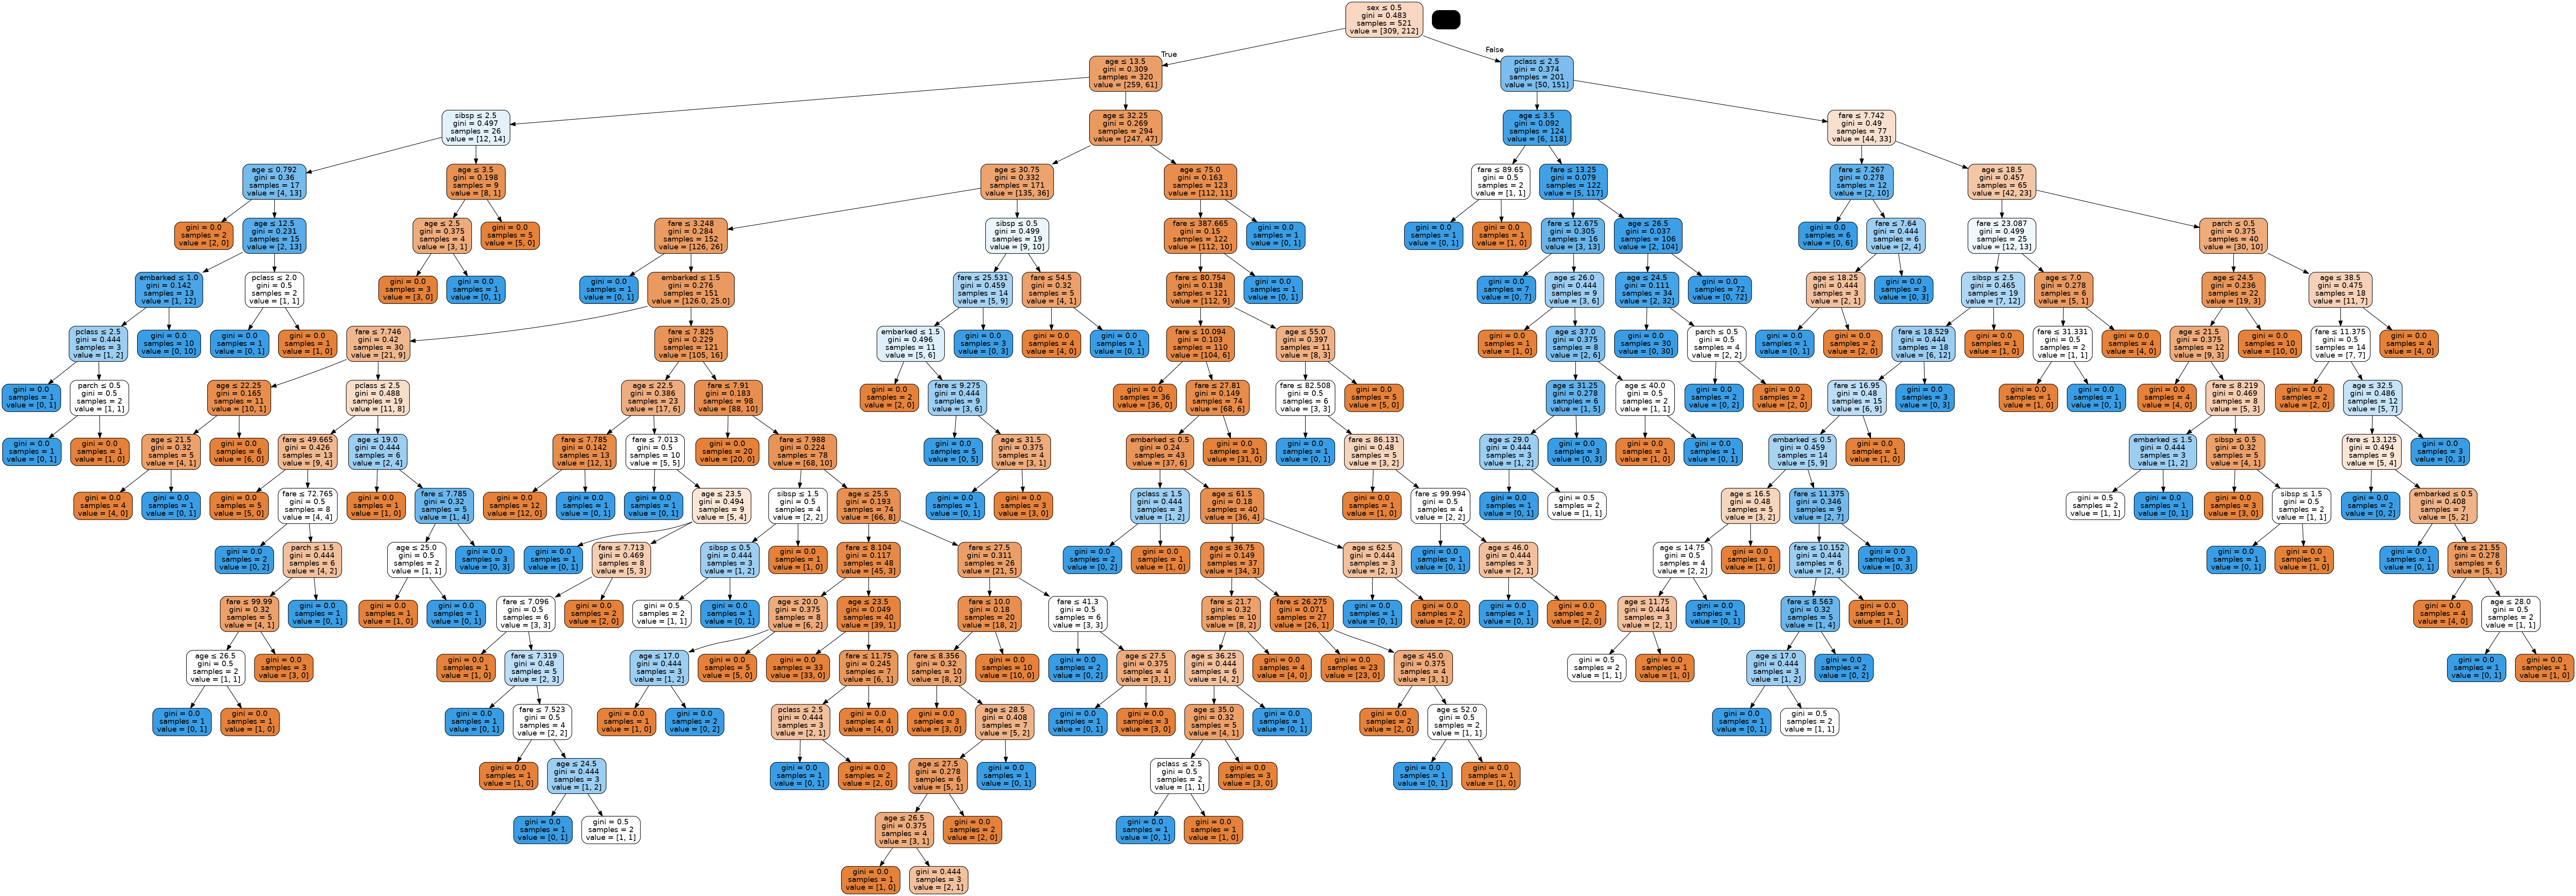

In [15]:
plot_tree(titanic_tree, X_train.columns)

In [16]:
# How many nodes and leaves?
print("Number of nodes: ", titanic_tree.tree_.node_count)
print("Number of leaves: ", titanic_tree.get_n_leaves())

Number of nodes:  261
Number of leaves:  131


We will plot the feature importance

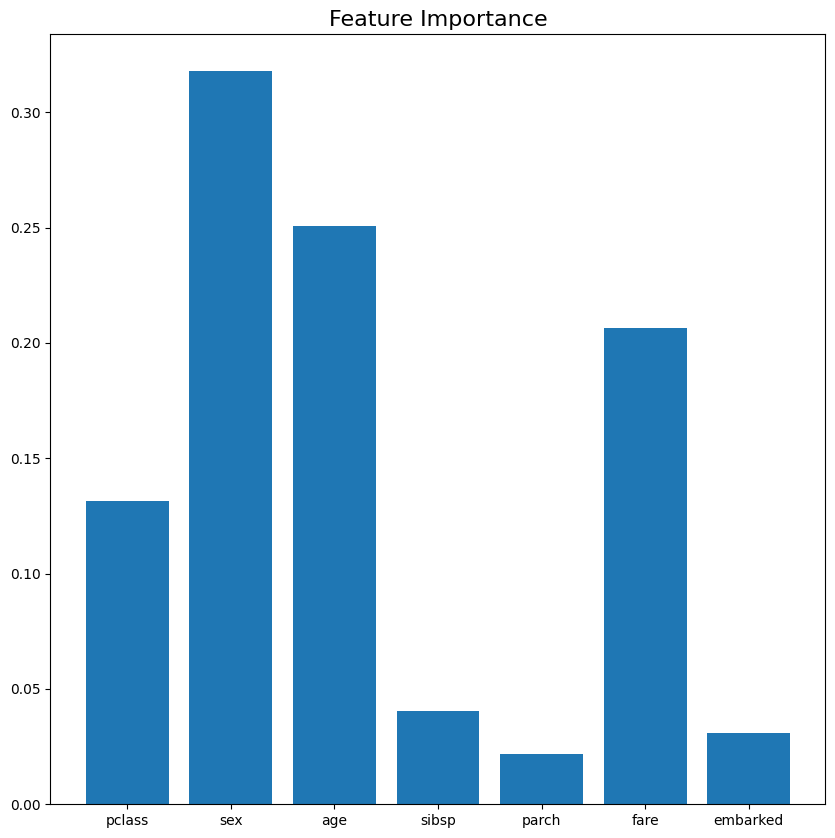

In [17]:
plt.figure(figsize=(10,10))
plt.bar(X_train.columns, titanic_tree.feature_importances_) #average reduction in impurity resulting from splitting at each node of the tree using that feature
plt.title('Feature Importance', fontsize=16);

### Pruning the tree

Now we will prune the tree to see if we can improve performance.

There are different Pruning Parameters:

 - max_leaf_nodes: Reduce the number of leaf nodes
 - min_samples_leaf: Restrict the size of sample leaf. Minimum sample size in terminal nodes can be fixed to 30, 100, 300 or 5% of total 
 - max_depth: Reduce the depth of the tree to build a generalized tree. Set the depth of the tree to 3, 5, 10 depending after verification on test data
 - etc..

Let's focus on the depth of the tree. We will test different depth thresholds via CV by using the `GridSearchCV` provided by sklearn.

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': range(1,16)} # 15 different depth levels

titanic_tree_pruned_cv = GridSearchCV(titanic_tree, 
                   param_grid,
                   scoring='accuracy',
                   cv=5 , n_jobs=1, verbose=1)

titanic_tree_pruned_cv.fit(X_train,Y_train);

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/codespace/.local/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [19]:
print("Best parameters set found on development set:")
print()
print(titanic_tree_pruned_cv.best_params_)
print()
print("Grid scores on development set:")
print()
means = titanic_tree_pruned_cv.cv_results_['mean_test_score']
stds = titanic_tree_pruned_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, titanic_tree_pruned_cv.cv_results_['params']):
    print("Accuracy = %0.3f (+/%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'max_depth': 3}

Grid scores on development set:

Accuracy = 0.787 (+/0.049) for {'max_depth': 1}
Accuracy = 0.802 (+/0.067) for {'max_depth': 2}
Accuracy = 0.827 (+/0.066) for {'max_depth': 3}
Accuracy = 0.814 (+/0.047) for {'max_depth': 4}
Accuracy = 0.804 (+/0.072) for {'max_depth': 5}
Accuracy = 0.787 (+/0.071) for {'max_depth': 6}
Accuracy = 0.771 (+/0.105) for {'max_depth': 7}
Accuracy = 0.771 (+/0.081) for {'max_depth': 8}
Accuracy = 0.762 (+/0.095) for {'max_depth': 9}
Accuracy = 0.741 (+/0.071) for {'max_depth': 10}
Accuracy = 0.748 (+/0.072) for {'max_depth': 11}
Accuracy = 0.754 (+/0.067) for {'max_depth': 12}
Accuracy = 0.745 (+/0.067) for {'max_depth': 13}
Accuracy = 0.756 (+/0.068) for {'max_depth': 14}
Accuracy = 0.741 (+/0.083) for {'max_depth': 15}


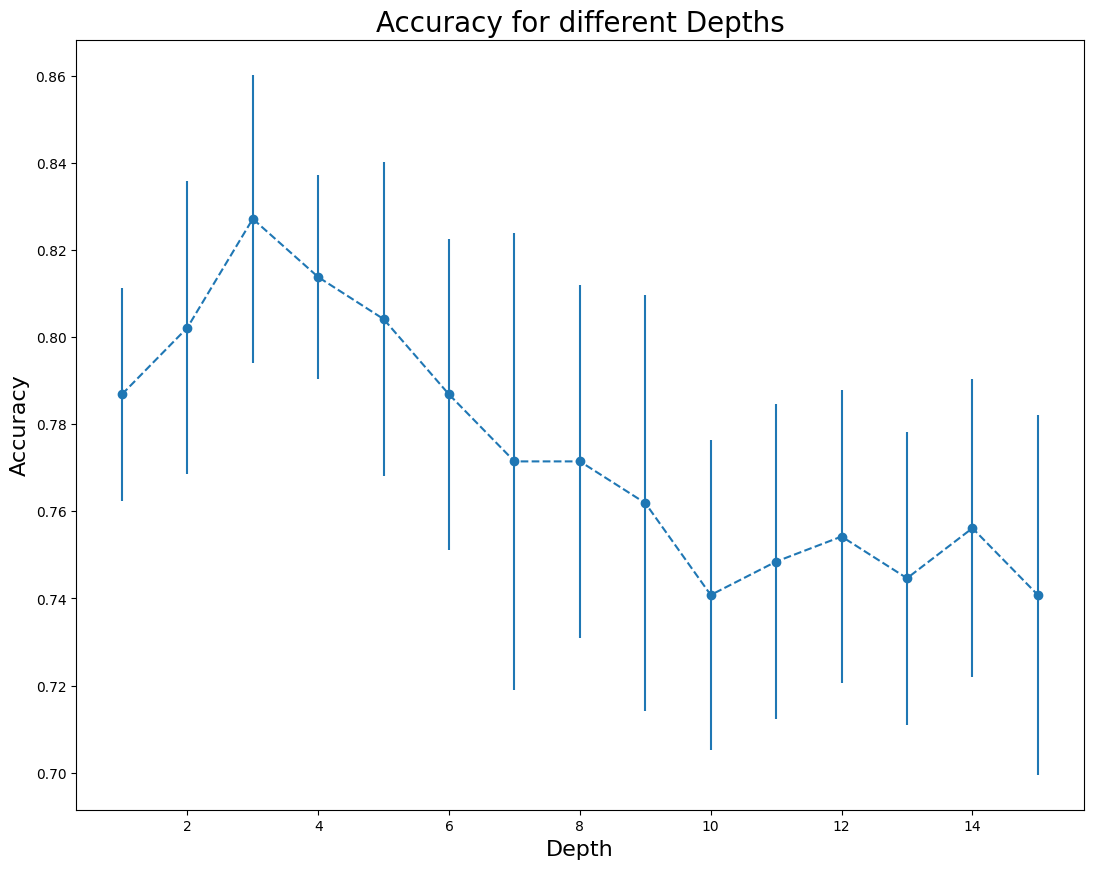

In [20]:
plt.figure(figsize=(13,10))
plt.errorbar(range(1,16,1), [m for m in means], yerr=stds, fmt='--o')
plt.title('Accuracy for different Depths', fontsize=20)
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16);

As can be seen in the plot, the optimal value for the depth of the decision tree is 3.

### Test data set

Let's now calculate accuracy for test data set

In [21]:
titanic_tree_pruned = DecisionTreeClassifier(random_state=42, max_depth=3)
tree=titanic_tree_pruned.fit(X_train, Y_train)
predictions = titanic_tree_pruned.predict(X_test)
print("Accuracy = {0:.4f}".format(accuracy_score(Y_test, predictions)))

from sklearn.metrics import recall_score, precision_score
prob_pred = tree.predict_proba(X_test)[:, 1]
thresholds = np.arange(0.0, 1.0, step=0.1)
recall_scores = [metrics.recall_score(Y_test, prob_pred > t) for t in thresholds]
precis_scores = [metrics.precision_score(Y_test, prob_pred > t) for t in thresholds]


Accuracy = 0.7854


Great! We have increase the accuracy with a smaller tree.

Now, we represent the different values for the metrics obtained using different thresholds

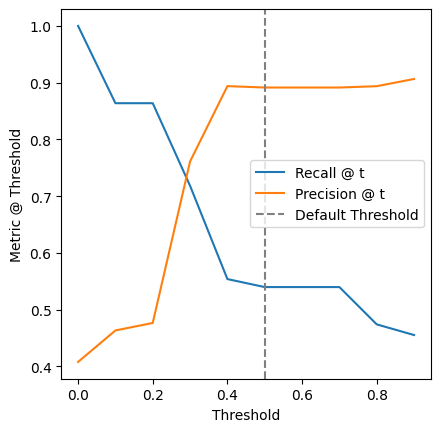

In [22]:
fig, ax = plt.subplots(1, 1)
ax.plot(thresholds, recall_scores, label="Recall @ t")
ax.plot(thresholds, precis_scores, label="Precision @ t")
ax.axvline(0.5, c="gray", linestyle="--", label="Default Threshold")
ax.set_xlabel("Threshold")
ax.set_ylabel("Metric @ Threshold")
ax.set_box_aspect(1)
ax.legend()
plt.show()

In [23]:
pred = tree.predict_proba(X_test) > 0.3
pred

array([[ True, False],
       [ True, False],
       [ True,  True],
       ...,
       [False,  True],
       [ True, False],
       [False,  True]])

In [24]:
# How many nodes and leaves?
print("Number of nodes: ", titanic_tree_pruned.tree_.node_count)
print("Number of leaves: ", titanic_tree_pruned.get_n_leaves())

Number of nodes:  15
Number of leaves:  8


And we can represent the set of rules

In [25]:
from sklearn import tree

text_representation = tree.export_text(titanic_tree_pruned)
print(text_representation)
with open("decision_tree.log", "w") as fout:
    fout.write(text_representation)

|--- feature_1 <= 0.50
|   |--- feature_2 <= 13.50
|   |   |--- feature_3 <= 2.50
|   |   |   |--- class: 1
|   |   |--- feature_3 >  2.50
|   |   |   |--- class: 0
|   |--- feature_2 >  13.50
|   |   |--- feature_2 <= 32.25
|   |   |   |--- class: 0
|   |   |--- feature_2 >  32.25
|   |   |   |--- class: 0
|--- feature_1 >  0.50
|   |--- feature_0 <= 2.50
|   |   |--- feature_2 <= 3.50
|   |   |   |--- class: 0
|   |   |--- feature_2 >  3.50
|   |   |   |--- class: 1
|   |--- feature_0 >  2.50
|   |   |--- feature_5 <= 7.74
|   |   |   |--- class: 1
|   |   |--- feature_5 >  7.74
|   |   |   |--- class: 0



### Visualization

We are going to deep down a bit more on the tree.<BR>


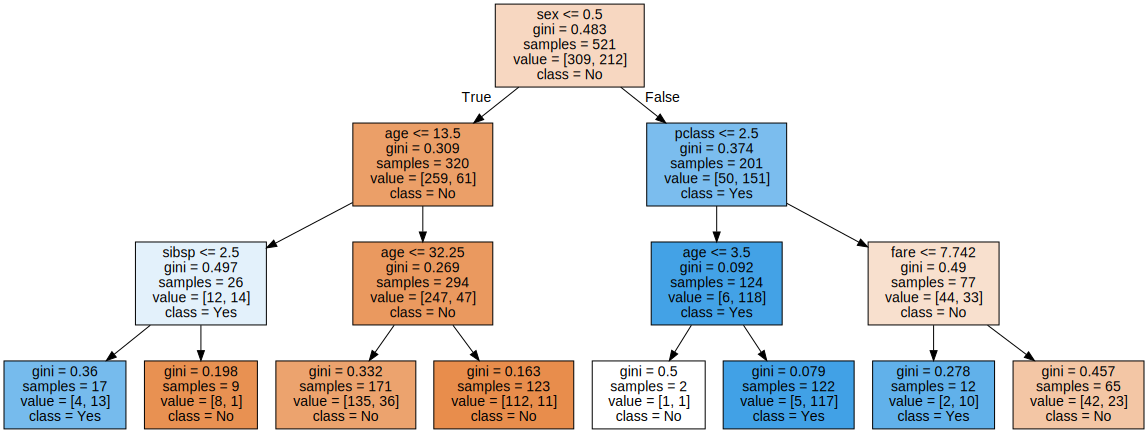

In [26]:
import graphviz
# DOT data
dot_data = tree.export_graphviz(titanic_tree_pruned, out_file=None, 
                                class_names=["No","Yes"],
                                feature_names=X_train.columns,  
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph

In [27]:
# Save it into a high resolution image
graph.render("titanic_tree_graphivz")

'titanic_tree_graphivz.png'

## Alternative visualization: dtreeviz
we need to install the powerful library *dtreeviz* for this

In [28]:
## ! pip install dtreeviz
import dtreeviz

viz_cmodel = dtreeviz.model(titanic_tree_pruned,
                           X_train=X_train,
                           y_train=Y_train,
                           feature_names=X_train.columns,
                           target_name='survived')
viz_cmodel.view(scale=1.5)

ModuleNotFoundError: No module named 'dtreeviz'

Display now frequencies for each node.<BR>

In [ ]:
viz_cmodel.leaf_sizes(figsize=(12,6))

We can see node id=6 is the one with maximum amount of people

In [ ]:
# Compare it with target classes
viz_cmodel.ctree_leaf_distributions(figsize=(12,6))

Let's explore that node

In [ ]:
viz_cmodel.node_stats(node_id=6)

And highlight it in the tree so that we can take a closer look at it

In [ ]:
x = X_train[X_train.columns].iloc[1]
viz_cmodel.view(x=x, scale=1.5)

## Model performance

Finally, let's going to analyze model performance (on test data set)

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(Y_test, predictions)

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(label_names,label_counts)]
labels = np.asarray(labels).reshape(2,2)

# Draw heatmap using confusion matrix
sns.heatmap(conf_mat, annot=labels, fmt='')
ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
